### CAPTURE SATELLITE IMAGES FOR PAST PERIOD WITH LANDSAT-5 (1984 - 2000)

In [1]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
from datetime import date
import json
from json import JSONEncoder

Authentification auprès de Google Engine :

Cliquer sur le lien et suivre les instructions (avec compte google connecté) pour récupérer le token à copier-coller.

In [2]:
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())


Successfully saved authorization token.
NASADEM: NASA NASADEM Digital Elevation 30m


-----------

IMPORT AND MANAGE DATA :

In [3]:
data = pd.read_excel('DataFrames/data_parcelles_with_gps.xlsx')

In [4]:
data_used = data[['PARCELLE','LAT', 'LON','DATE','LFI']]

Filtrage de campagne :

In [5]:
LFI = 'LFI4'

data_used = data_used.loc[data_used['LFI']==LFI,:]

Code for a test on few lines :

In [114]:
#data_used = data_used[0:5]

Code for a problematic relaunch (to filter the dataset with the problematic parcelles list) :

In [17]:
pb_list_df = pd.read_csv('Problematic_parcelles.csv')
pb_list = pb_list_df['Problematic parcelles'].to_list()
data_used = data_used.loc[data_used['PARCELLE'].isin(pb_list),:]
len(data_used)

--------------------------

CLASS FOR EXCEPTIONS :

In [6]:
class NoImage(Exception):
    def __init__(self, nb_image):
        self.__nb_image = nb_image

    @property
    def nb_image(self):
        return self.__nb_image

In [7]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (datetime, date)):
            return str(obj)
        return json.JSONEncoder.default(self, obj)

FUNCTIONS (FOR LANDSAT-5 & 7):

In [8]:
def NDVI(img): #repère la végétation tout simplement
    img = ee.Image(img.normalizedDifference(['B4', 'B3'])).rename(["ndvi"])
    return img

def EVI(img): #idem NDVI, plus fiable et fin en théorie
    img = ee.Image(img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': img.select('B4').divide(10000),
            'RED': img.select('B3').divide(10000),
            'BLUE': img.select('B1').divide(10000)
        })).rename(["evi"])
    
    return img

def NDMI(img): #repère la teneur en eau dans la végétation
    #img = ee.Image(img.normalizedDifference(['B8', 'B11'])).rename(["ndmi"])
    img = ee.Image(img.expression(
        '(NIR - SWITCH) / (SWITCH + NIR)', {
            'NIR': img.select('B4').divide(10000),
            'SWITCH': img.select('B5').divide(10000)
       })).rename(["ndmi"])
    return img

def NDWI(img): #teneur en d'eau en surface
    #img = ee.Image(img.normalizedDifference(['B3', 'B8'])).rename(["ndwi"])
    img = ee.Image(img.expression(
        '(GREEN - NIR) / (GREEN + NIR)', {
            'NIR': img.select('B4').divide(10000),
            'GREEN': img.select('B2').divide(10000)
        })).rename(["ndwi"])
    return img


def DSWI(img): # Disease Water Stress Index sensitive to stress due to water shortage and plant damage
    img = ee.Image(img.expression(
        '(NIR - GREEN) / (SWIR1 + RED)', {
            'NIR': img.select('B4').divide(10000),
            'RED': img.select('B3').divide(10000),
            'GREEN': img.select('B2').divide(10000),
            'SWIR1': img.select('B5').divide(10000),
        })).rename(["dswi"])
    
    return img

def B1(img):
    b2 = ee.Image(img.select(['B1'])).divide(10000).rename(["b1"])
    return b2

def B2(img):
    b2 = ee.Image(img.select(['B2'])).divide(10000).rename(["b2"])
    return b2

def B3(img):
    b3 = ee.Image(img.select(['B3'])).divide(10000).rename(["b3"])
    print('add b3')
    return b3

def B4(img):
    b4 = ee.Image(img.select(['B4'])).divide(10000).rename(["b4"])
    return b4

def B5(img):
    b5 = ee.Image(img.select(['B5'])).divide(10000).rename(["b5"])
    return b5

In [9]:
def collection_to_array(lat_loc, lon_loc, date_dep, date_fin):
    global dim_image, percentage_max_cloud_cover, Spectral_Band_init, Spectral_Functions, Sattelite
    pas_lat = dim_image/111120
    pas_lon = dim_image/111120

    area = ee.Geometry.BBox(lon_loc - pas_lon/2, lat_loc-pas_lat/2, lon_loc + pas_lon/2, lat_loc + pas_lat/2)
    pas_lon_cos = dim_image/(111120 * np.cos(lat_loc*np.pi/180))
    area_cos = ee.Geometry.BBox(lon_loc - pas_lon_cos/2, lat_loc-pas_lat/2, lon_loc + pas_lon_cos/2, lat_loc + pas_lat/2)

    collection = ee.ImageCollection(Sattelite).filterBounds(area_cos) \
                                      .filterDate(date_dep,date_fin) \
                                      #.filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",percentage_max_cloud_cover)\
                                      #.select(Spectral_Band_init) \
                                      
                                      
    print('collection')
    nb_images = collection.size().getInfo()
    print(f'{nb_images} images founded...')

    if nb_images == 0:
        raise NoImage(nb_images)

    im_dict = dict()

    
    for _, funct in enumerate(Spectral_Functions):
        myCollection  = collection.map(Spectral_Functions.get(funct))
        img = ee.Image(myCollection.mean()).rename(['result'])
        img = img.addBands(ee.Image.pixelLonLat())
        img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e8,\
                                        scale=1)
        data = np.array((ee.Array(img.get('result')).getInfo()))
        lats = np.array((ee.Array(img.get("latitude")).getInfo()))
        lons = np.array((ee.Array(img.get("longitude")).getInfo()))
        uniqueLats = np.unique(lats)
        uniqueLons = np.unique(lons)
        ncols = len(uniqueLons)
        nrows = len(uniqueLats)
        arr = np.zeros([nrows, ncols], np.float32)
        counter =0
        for y in range(0,len(arr),1):
            for x in range(0,len(arr[0]),1):
                if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                    counter+=1
                    arr[len(uniqueLats)-1-y,x] = data[counter]

        im_dict[f'{funct}'] = arr

        if funct==NDVI:
            im_dict[f'TNDVI'] = np.sqrt(arr) + 0.5
    
    return im_dict
    

--------------

USER'S PARAMETERS :

In [10]:
Sattelite = 'LANDSAT/LE07/C02/T1'

dim_image = 200 #mètres de côté

OTHERS PARAMETERS

Paramètre de pourcentage de couverture nuageuse (filtre) :

In [12]:
#percentage_max_cloud_cover = 100

Besoins en bandes spectrales (pour les fonctions) :

In [37]:
#Spectral_Band_init = ['B2', 'B3', 'B4', 'B5']

Important : garder le format dictionnaire

In [11]:
Spectral_Functions = {'NDVI':NDVI, 'EVI':EVI, 'NDMI':NDMI, 'NDWI':NDWI, 'DSWI':DSWI}

Moitié d'ouverture temporelle (centrée au 30 juin) :

In [19]:
days = 30

La collection d'images se fera entre date - days et date + days...

------------

IMAGES CAPTURE :

In [20]:
data_lfi = data_used.loc[data_used['LFI']==LFI,:]
data_lfi['YEAR'] = data_lfi['DATE'].map(lambda d : d.year)
if LFI=='LFI1':
    data_lfi['YEAR'] = data_lfi['YEAR'].map(lambda d: 1984 if d==1983 else d)
print (f"For campaign {LFI}, all the images will be extracted for this years : {data_lfi['YEAR'].unique()}...")

# --- FORCE TEST YEAR --- 
#data_lfi['YEAR'] = 1990

#data_lfi = data_lfi[0:5]

# --- END TEST ---

nb_lines = len(data_lfi)
matrix_data = np.matrix(data_lfi)

Stock_images_list =dict()
Problem_list = []

for i in range(nb_lines):
    deb_image = time.time()
    parc_name = matrix_data.item(i, 0)
    print(f'--- PARCELLE {matrix_data.item(i, 0)} ---')
    parc_dict=dict()
    date_image = datetime.datetime.strptime(str(matrix_data.item(i, 5)) + '-06-30', '%Y-%m-%d')
    date_dep = (date_image - datetime.timedelta(days=days))
    date_fin = (date_image + datetime.timedelta(days=days))
    date_dep_string = str(date_dep.year) + '-' + str(date_dep.month) + '-' + str(date_dep.day)
    date_fin_string = str(date_fin.year) + '-' + str(date_fin.month) + '-' + str(date_fin.day)
    lat_loc = matrix_data.item(i, 1)
    lon_loc = matrix_data.item(i, 2)

    try:
        dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
    except NoImage:
        date_dep -= datetime.timedelta(days=days)
        date_fin += datetime.timedelta(days=days)
        print(f'Zéro images for parcelle {parc_name}... so we tried with a days open of {days*4} days...')
        try:
            dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
        except NoImage:
            date_dep -= datetime.timedelta(days=days)
            date_fin += datetime.timedelta(days=days)
            print(f'Zéro images for parcelle {parc_name}... so we tried with a days open of {days*8} days...')
            try:
                dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
            except:
                print(f'--- PROBLEM ! with parcelle {parc_name}... ---')
                dict_images = np.nan
                Problem_list.append(parc_name)
        except:
            print(f'--- PROBLEM ! with parcelle {parc_name}... ---')
            dict_images = np.nan
            Problem_list.append(parc_name)
    except:
        print(f'--- PROBLEM ! with parcelle {parc_name}... ---')
        dict_images = np.nan
        Problem_list.append(parc_name)


    parc_dict['PARCELLE'] = matrix_data.item(i, 0)
    parc_dict['LAT, LON'] = (lat_loc, lon_loc)
    parc_dict['DATE_INIT'] = str(matrix_data.item(i, 3))
    parc_dict['LFI'] = matrix_data.item(i, 4)
    parc_dict['DATE_IMAGE_SAT'] = str(date_image)
    parc_dict['IMAGES_SAT'] = dict_images
    Stock_images_list[f'{matrix_data.item(i, 0)}'] = parc_dict
    fin_image = time.time()
    print(f'This image traitment took {round(fin_image - deb_image,4)} seconds... ')

print('Finish !...')
print(f'But we have a problem with this list of parcelles : {Problem_list}')


For campaign LFI4, all the images will be extracted for this years : [2016 2011 2009 2010 2017 2013 2015 2012 2014]...
--- PARCELLE 9423 ---
collection
6 images founded...
This image traitment took 20.9945 seconds... 
--- PARCELLE 12298 ---
collection
3 images founded...
This image traitment took 17.4136 seconds... 
--- PARCELLE 13440 ---
collection
3 images founded...
This image traitment took 33.5007 seconds... 
--- PARCELLE 16610 ---
collection
5 images founded...
This image traitment took 26.3357 seconds... 
--- PARCELLE 18284 ---
collection
5 images founded...
This image traitment took 24.4511 seconds... 
--- PARCELLE 18516 ---
collection
3 images founded...
This image traitment took 21.8321 seconds... 
--- PARCELLE 19913 ---
collection
3 images founded...
This image traitment took 23.8116 seconds... 
--- PARCELLE 19973 ---
collection
3 images founded...
This image traitment took 27.0412 seconds... 
--- PARCELLE 19985 ---
collection
3 images founded...
This image traitment took 20

---------------

#### EXPORTS

option 1 : export in slicing mode :

In [51]:
nb_parts = 8 # to define number of parts of the unique dict

In [52]:
Decoup_stock_images = []

len_sub_list = len(Stock_images_list)//nb_parts

for i in range(nb_parts-1):
    Decoup_stock_images.append(dict(list(Stock_images_list.items())[i*len_sub_list:(i+1)*len_sub_list]))
Decoup_stock_images.append(dict(list(Stock_images_list.items())[(nb_parts-1)*len_sub_list:]))

In [53]:
for i in range(nb_parts):
    print(f'... Exportation of dict n°{i} (lenght : {len(Decoup_stock_images[i])}) in a jsonfile...')
    list_json = json.dumps(Decoup_stock_images[i], cls=NumpyArrayEncoder)
    with open(f"Results_Images_Stock/Images_{Sattelite.split('/')[0].split('-')[0]}_{LFI}_part{i+1}.json", "w") as outfile:
        outfile.write(list_json)
    print(f'... Exportation dict n°{i} done...')

... Exportation of dict n°0 (lenght : 25) in a jsonfile...
... Exportation dict n°0 done...
... Exportation of dict n°1 (lenght : 25) in a jsonfile...
... Exportation dict n°1 done...
... Exportation of dict n°2 (lenght : 25) in a jsonfile...
... Exportation dict n°2 done...
... Exportation of dict n°3 (lenght : 25) in a jsonfile...
... Exportation dict n°3 done...
... Exportation of dict n°4 (lenght : 25) in a jsonfile...
... Exportation dict n°4 done...
... Exportation of dict n°5 (lenght : 25) in a jsonfile...
... Exportation dict n°5 done...
... Exportation of dict n°6 (lenght : 25) in a jsonfile...
... Exportation dict n°6 done...
... Exportation of dict n°7 (lenght : 26) in a jsonfile...
... Exportation dict n°7 done...


option 2 : Export in a unique json file :

In [21]:
print('... Exportation in a jsonfile...')

list_json = json.dumps(Stock_images_list, cls=NumpyArrayEncoder)
with open(f"Results_Images_Stock/Images_{Sattelite.split('/')[0].split('-')[0]}_{LFI}_pb1.json", "w") as outfile:
    outfile.write(list_json)

print('... Exportation done...')



... Exportation in a jsonfile...
... Exportation done...
... Exportation of the problematic parcelle's list in a text...
...Exportation done...


Export of the problematic list :

In [ ]:
print('... Exportation of the problematic parcelle\'s list in a text...')

df_pb_list = pd.DataFrame(Problem_list, columns=['Problematic parcelles'])
df_pb_list.to_csv('Problematic_parcelles_part2.csv')

print('...Exportation done...')

---------------

Test ouverture de fichier :

In [133]:
with open(f"Results_Images_Stock/Images_{Sattelite.split('/')[0].split('-')[0]}_{LFI}.json", 'r') as openfile:
 
    json_object = json.load(openfile)

In [134]:
json_object['51'].get('DATE_INIT')

'2005-11-01 00:00:00'

In [121]:
json_object['51'].get('DATE_IMAGE_SAT')

'2005-06-30 00:00:00'

In [136]:
json_object['51'].get('LAT, LON')

[47.78162341651316, 8.612821767035694]

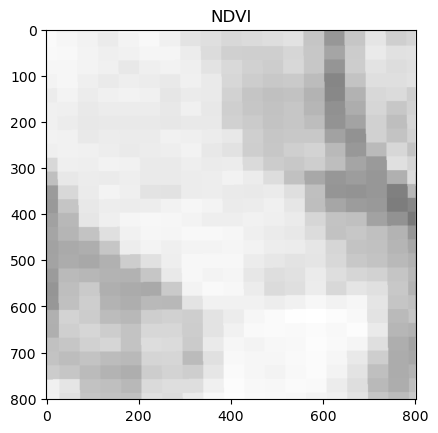

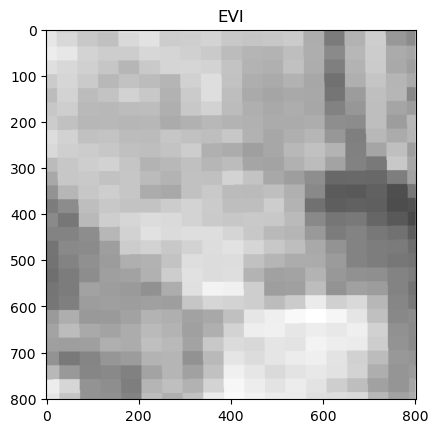

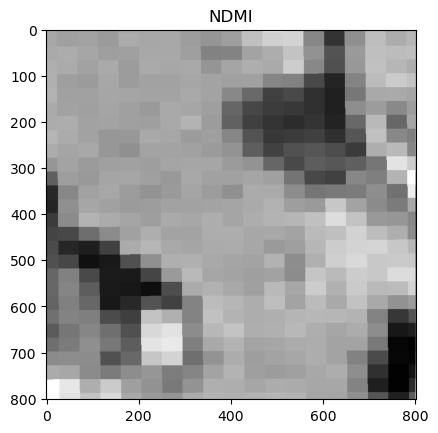

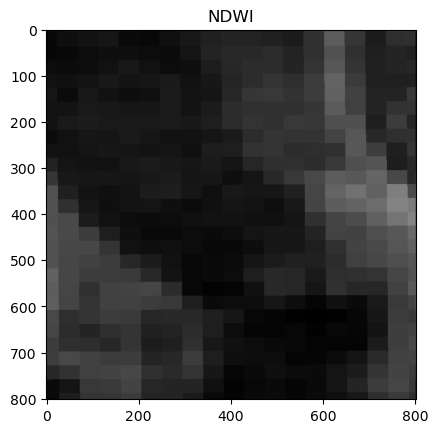

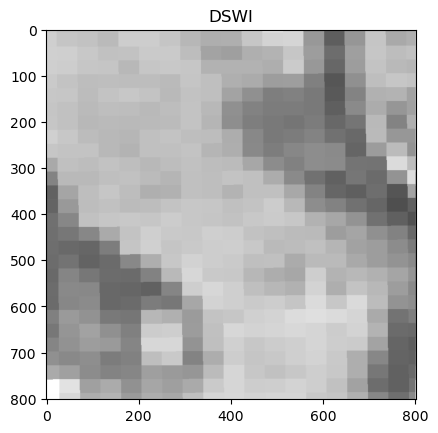

In [123]:
for _, funct in enumerate(json_object['51'].get('IMAGES_SAT')):
    plt.title(f'{funct}')
    plt.imshow(json_object['51'].get('IMAGES_SAT').get(funct), 'gray')
    plt.show()